# Data Analysis 
I will be using this notebook to analyse the data I have recorded, find correllations, and see if my assumptions about the data are correct or not. I would also like to acknowledge here that the process of recording the data was not perfect as the F125's violation system can be inconsistent at times. Another thing to mention is that the region where a driver brakes or hits the throttle are not the only factors that can cause them to crash or violate the track limits, there can be other reasons like the position of their steering, wheel, track conditions, etc. that are not in the scope of this project.

## Assumptions
My assumptions are as follows:

- I believe that the time between the moment a driver hits the brakes and hits the throttle is correllated to the overall lap time. My reasoning is that if the time difference between those inputs is too high, the car is slower for longer.
- I think that the number of times a car brakes is also correllated to the overall lap time. I think this is because the car is slowing down at another point in the lap which may be unneccessary if the driver takes a better racing line with lesser number of braking needed but this may be wrong as sometimes slowing down to take a turn and hitting the apex can be better than forcing the car to turn at a higher speed and missing the apex.
-  

## Exploring the data 
In the code chunk below I have imported all the libraries I require for the data analysis and have loaded the data as well.

In [32]:
# FIRST EDITED: 14/02/2026

import csv
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("../Data/collated-data/lap-image-association.csv")

# in the arrays below, s1 means sector 1
s1_num = df["lap_num"].to_numpy()
s1_times = df["s1_time"].to_numpy()
s1_incident = df["incident"].to_numpy()
s1_b_t_deltas = df["brake_throttle_deltas"].to_numpy()
s1_brake_hits = df["related_b_hits"].to_numpy()
s1_throttle_hits = df["related_t_hits"].to_numpy()
#print(df.head)

# LAST EDITED: 14/02/2026

In the code chunk below, I will some plot data.

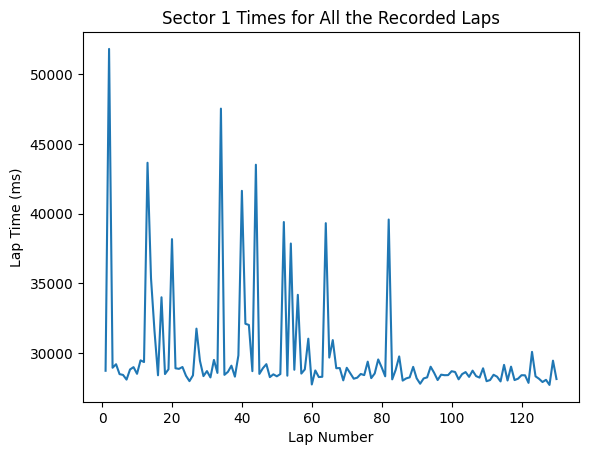

In [33]:
# FIRST EDITED: 14/02/2026

plt.plot(s1_num, s1_times)
plt.title("Sector 1 Times for All the Recorded Laps")
plt.xlabel("Lap Number")
plt.ylabel("Lap Time (ms)")

plt.show()

# LAST EDITED: 14/02/2026

There seem to be some laps that have very high sector-1 times and that is most probably due to a crash or track limit violation. These incidents result in the car having to get back to the track which takes a while (it should be noted that when I record this data the car is made indestructible to avoid repairs and ensure that all laps have the exact same car). In the code chunk below I will create a data frame without these incidents.

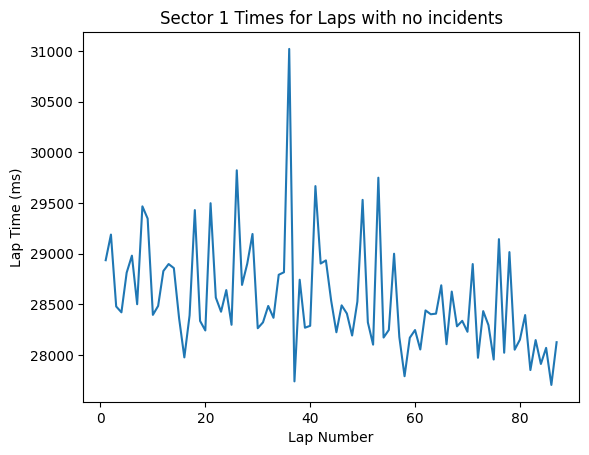

In [34]:
# FIRST EDITED: 14/02/2026

clean_df = df[df['incident'] == 'none']
clean_s1_times = clean_df["s1_time"].to_numpy()

#print(clean_df.head)

# Since the actual lap numbers may create the illusion that the number of laps
# without an incident are the same as the laps with an incident, I am going to use
# a simple range on the y-axis

pseudo_lap_num = np.arange(1, clean_s1_times.shape[0] + 1)

plt.plot(pseudo_lap_num, clean_s1_times)
plt.title("Sector 1 Times for Laps with no incidents")
plt.xlabel("Lap Number")
plt.ylabel("Lap Time (ms)")

plt.show()
#print(clean_s1_times)

# LAST EDITED: 14/02/2026

Perhaps I should exclude laps with a sector-1 time higher than 30000ms. Another thing of note here is that I have improved at driving around the first sector of the lap after 100s of laps which might be why the later laps quicker. In the next code chunk I will remove laps with an unusually long secto-1 time (> 30000ms) and create arrays for the rest of the columns for later use.

Text(0, 0.5, 'Lap Time (ms)')

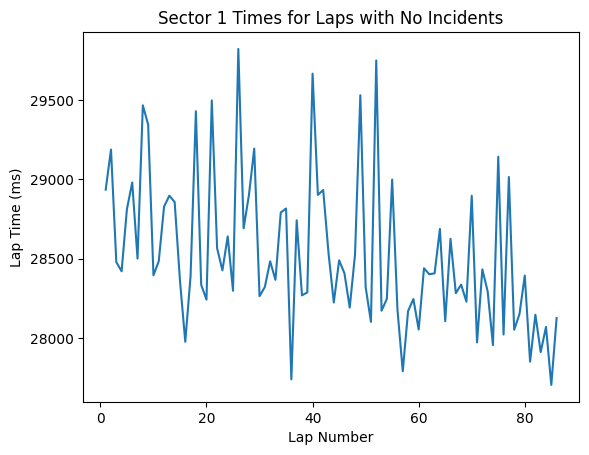

In [36]:
# FIRST EDITED: 14/02/2026

clean_df = clean_df[clean_df['s1_time'] < 30000]
clean_s1_num = clean_df["lap_num"].to_numpy()
clean_s1_times = clean_df["s1_time"].to_numpy()
clean_s1_b_t_deltas = clean_df["brake_throttle_deltas"].to_numpy()
clean_s1_brake_hits = clean_df["related_b_hits"].to_numpy()
clean_s1_throttle_hits = clean_df["related_t_hits"].to_numpy()

pseudo_lap_num = np.arange(1, clean_s1_times.shape[0] + 1)

plt.plot(pseudo_lap_num, clean_s1_times)
plt.title("Sector 1 Times for Laps with No Incidents")
plt.xlabel("Lap Number")
plt.ylabel("Lap Time (ms)")

# LAST EDITED: 14/02/2026

Now, without the outlier being present, my assumption about the lap times getting lower as I record more data seems more likely. I may need to find a way to account for this improvement but before doing that I will create three more variables from the cleaned data frame, they are:

- avg_b_t_delta: Average gap between a break and a throttle hit
- brake_hits: Times brakes were hit in sector-1
- throttle_hits: Times throttle as hit in sector-1

I will do so in the following code chunk.

In [ ]:
# FIRST EDITED: 14/02/2026

avg_b_t_delta = [] #only recorded from session-6
brake_hits = []
throttle_hits = []

for i in range(clean_s1_times.shape[0]):\

    brakes = str(clean_s1_brake_hits[0])
    brakes = brakes.split(', ')
    brake_hits.append(len(brakes))

    throttles = str(clean_s1_throttle_hits[0])
    throttles = throttles.split(', ')
    throttle_hits.append(len(throttles))

    
    #print(type(clean_s1_b_t_deltas[i]))
    if clean_s1_b_t_deltas[i] == '[]':
        avg_b_t_delta.append(0)
    else:
        # TODO: fix this
        b_t_d = str(clean_s1_b_t_deltas[i])
        b_t_d = b_t_d.split(', ')
        print(b_t_d[0])

#print(brake_hits)


# LAST EDITED: 14/02/2026

[[1.330505132675171
[[1.3782010078430176
[[1.6070523262023926
[[1.4015560150146484
[[1.4284217357635498
[[1.6907281875610352
[[1.0230348110198975
[[1.6941251754760742
[[1.1517844200134277
[[1.1383581161499023
[[2.2132835388183594
[[1.325571060180664
[[1.1870827674865723
[[1.6241118907928467
[[1.184779167175293
[[1.6503453254699707
[[1.7128939628601074
[[1.1617155075073242
[[2.275329828262329
[[2.0936031341552734
[[1.513024091720581
[[1.0171310901641846
[[1.6160471439361572
[[1.0975801944732666
[[1.2195510864257812
[[1.5193328857421875
[[1.114410638809204
[[1.1045451164245605
[[1.114415168762207
[[1.0357439517974854
[[1.030689001083374
[[1.5264620780944824
[[1.6163814067840576
[[1.0614550113677979
[[1.7636568546295166
[[1.5302379131317139
[[1.137732744216919
[[1.4306564331054688
[[1.378577470779419
[[1.0863780975341797
[[1.7046334743499756
[[1.100811243057251
[[1.529008388519287
[[1.3910863399505615
[[1.5470032691955566
[[2.0748109817504883
[[1.1826441287994385
[[1.6333818435668945
[[1.